In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import IQP, EfficientSU2
from qiskit.circuit.parametervector import ParameterVector, ParameterVectorElement
from qiskit.circuit import Parameter
from qiskit import quantum_info as qiskit_info
from qiskit.circuit.random import random_circuit
from qiskit import Aer
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, transpile
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi

from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_hinton
from qiskit.extensions import UnitaryGate
import matplotlib.pyplot as plt
from qiskit import IBMQ, Aer, assemble, transpile
import scipy.linalg as ln
import math 
%matplotlib inline
import random
from math import pi
import struct
from circuit_generator import QCircuit_to_layers
from circuit_generator import my_random_circuit

/var/folders/7w/fmjh0fp97z9475lnbtnqvnmr0000gn/T/ipykernel_4652/3756390107.py:18: DeprecationWarning: The qiskit.extensions module is deprecated since Qiskit 0.46.0. It will be removed in the Qiskit 1.0 release.
  from qiskit.extensions import UnitaryGate


/opt/homebrew/lib/python3.12/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


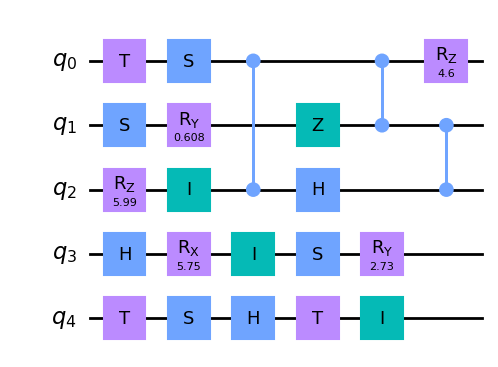

In [2]:
#gera circuito aleatório
qc = my_random_circuit(5,5, measure=False)
qc.draw(output='mpl')

In [9]:
#This code simulates a quantum circuit locally

shots=1000000

sim_statevector = AerSimulator(method='statevector')


def execute_locally(qc, draw_circuit=False):
    qcm=qc.copy()
    cr = ClassicalRegister(qcm.num_qubits, "c")
    qr = QuantumRegister(qcm.num_qubits, "q")
    qcm.add_register(cr)
    qcm.measure(qr, cr)
    job_statevector = sim_statevector.run(qcm, shots=shots)
    #print(job_statevector.result().get_statevector())
    result_counts = job_statevector.result().get_counts(0)
    if draw_circuit==True:
        qcm.draw()
    return result_counts

qcm=qc.copy()
cr = ClassicalRegister(qcm.num_qubits, "c")
qr = QuantumRegister(qcm.num_qubits, "q")
qcm.add_register(cr)
qcm.measure(qr, cr)
job_statevector = sim_statevector.run(qcm, shots=shots)
result=job_statevector.result()
print(result.get_statevector())

In [10]:
#the code runs a quantum simulation and prints the result counts (measurement outcomes)
res=execute_locally(qc,draw_circuit=True)
print(res)
qc.draw()

#The bitstring '00110' was the result of measuring the quantum state of the qubits.
#It appeared X times during the simulation when measuring the quantum system a total of 1000000 times.

QiskitError: 'No statevector for experiment "None"'

In [5]:
#Probability of each possible measurement outcome 
#for a quantum circuit with n qubits, 
# based on the results of the simulation (res)

n=qc.num_qubits
N=2**n

def pad_with_zeros(string, length):
    if len(string) >= length:
        return string
    else:
        zeros_to_add = length - len(string)
        padded_string = '0' * zeros_to_add + string
        return padded_string

results=np.zeros(N,dtype='float64')

    
for i in range(N):
    bvalue=bin(i)[2:]
    bvalue=pad_with_zeros(str(bvalue),n)
    results[i] = res.get(bvalue,0)/shots
    
    
print(results)

#probability of obtaining a specific outcome after measuring the quantum system
# the first one is for 00000, the second for 00001, etc

[0.113933 0.       0.011061 0.       0.113722 0.       0.011071 0.
 0.113513 0.       0.011294 0.       0.113585 0.       0.011353 0.
 0.113453 0.       0.01129  0.       0.114005 0.       0.011177 0.
 0.114129 0.       0.011282 0.       0.114043 0.       0.011089 0.      ]


In [6]:
def save_circuit(fileName):
    num_qubits = qc.num_qubits
    layers,num_layers= QCircuit_to_layers(qc)
    
    with open(fileName, 'wb') as outfile:  

        # The  first struct characterizes the circuit height (num_qubits) and width (num_layers)
        # In C struct {int num_qubits, int num_layers}
        outfile.write(struct.pack('=ii', num_qubits, num_layers))

        # Now iterate over layers to save the respective gates
        for l,layer in enumerate(layers):
            # Let us first count the number of:
            #. 1 qubit 0 parameters gates   G1P0
            #. 1 qubit 1 parameter gates    G1P1
            #. 2 qubits 0 parameters gates  G2P0
            #. 2 qubits 1 parameters gates  G2P1
            # NOT: ignore repeated gates and 'id' gates
            taken_qubits = []
            GList = [[],[],[],[]]    # G1P0,G1P1,G2P0,G2P1
            for gate in layer:
                gtype = gate[0]

                #if gtype == 'id': continue   # ignore identity

                new_gate = True   # is this a repeated gate ?
                                  # Note that this happens with
                                  # multiple qubit gates
                                  # due to legacy reasons
                for qb in gate[1]:    # qubits this gate acts upon
                    if qb in taken_qubits:
                        new_gate = False
                        break

                if not new_gate: continue

                # remember these qubits heve been used 
                taken_qubits += gate[1]

                if len(gate[1])==1 and gate[2]==[]:
                    GList[0].append(gate)
                elif len(gate[1])==1 and gate[2]!=[]:
                    GList[1].append(gate)
                elif len(gate[1])==2 and gate[2]==[]:
                    GList[2].append(gate)
                elif len(gate[1])==2 and gate[2]!=[]:
                    GList[3].append(gate)

            # For each layer the  1st structure indicates 
            # how many gates of each different count (qubits and params)
            # there are
            # In C struct {int G1P0,G1P1,G2P0,G2P1}
            outfile.write(struct.pack('=iiii', len(GList[0]), len(GList[1]), len(GList[2]), len(GList[3])))

            # Now let us save each gate, sorted by type: G1P0,G1P1,G2P0,G2P1
            for idx, gtl in enumerate(GList):   # G1P0,G1P1,G2P0,G2P1
                if (idx==0):       # G1P0
                    # these are 1 qubit gates without parameters
                    # Gate names coded as integers
                    # 'id' - 0
                    # 'h'  - 1
                    # 'x'  - 2
                    # 'y'  - 3
                    # 'z'  - 4
                    # 's'  - 5
                    # 't'  - 6
                    # C struct struct {char[] type, int qubit }
                    for gate in gtl:   # each G1P0 gate
                        if gate[0]=='id':      # Identity
                            gname = 0 
                        elif gate[0]== 'h':      # Hadamard
                            gname = 1 
                        elif gate[0]== 'x':      # X
                            gname = 2 
                        elif gate[0]== 'y':      # Y
                            gname = 3 
                        elif gate[0]== 'z':      # Z
                            gname = 4 
                        elif gate[0]== 's':      # S
                            gname = 5 
                        elif gate[0]== 't':      # T
                            gname = 6 
                        else:        # Unknown gate
                            print ("Error: Unsupported Gate!!!!")
                            gname = 0 
                        #print ("Layer {0}, gate {1}, qubit {2}".format(l,gname,gate[1][0]))
                        outfile.write(struct.pack('=ii', gname, gate[1][0]))
                elif (idx==1):       # G1P1
                    # these are 1 qubit gates with 1 parameter
                    # Gate names coded as integers
                    # 'rx'  - 11
                    # 'ry'  - 12
                    # 'rz'  - 13
                    # 'p'  - 14
                    # C struct struct {char[] type, int qubit, float param, float 8x matrix}
                    for gate in gtl:   # each G1P1 gate
                        if gate[0]=='rx':      # RX
                            gname = 11 
                        elif gate[0]== 'ry':      # RY
                            gname = 12 
                        elif gate[0]== 'rz':      # RZ
                            gname = 13 
                        elif gate[0]== 'p':      # P
                            gname = 14 
                        else:        # Unknown gate
                            print ("Error: Unsupported Gate!!!!")
                            gname = 0 
                        #print ("Layer {0}, gate {1}, param {2}, m[0][0]I {3}, pdf[0][0] {4}".format(l,gname,gate[2][0], gate[3][0][0].imag, , gate[4][0][0]))
                        outfile.write(struct.pack('=iifffffffff', gname, gate[1][0], gate[2][0],
                                                 gate[3][0][0].real, gate[3][0][0].imag,
                                                 gate[3][0][1].real, gate[3][0][1].imag,
                                                 gate[3][1][0].real, gate[3][1][0].imag,
                                                 gate[3][1][1].real, gate[3][1][1].imag))
                elif (idx==2):       # G2P0
                    # these are 2 qubit gates without parameters
                    # Gate names coded as integers
                    # 'id2'  - 20    Used for errors
                    # 'cx'  - 21
                    # 'cz'  - 22
                    # C struct struct {char[] type, int c_qubit, int t_qubit }
                    for gate in gtl:   # each G1P0 gate
                        if gate[0]=='cx':      # Identity
                            gname = 21 
                        elif gate[0]== 'cz':      # Hadamard
                            gname = 22 
                        else:        # Unknown gate
                            print ("Error: Unsupported Gate!!!!")
                            gname = 20 
                        #print ("Layer {0}, gate {1}, c_qubit {2}, t_qubit {3}".format(l,gname,gate[1][0],gate[1][1]))
                        outfile.write(struct.pack('=iii', gname, gate[1][0], gate[1][1]))
                elif (idx==3):       # G2P1
                    # these are 2 qubits gates with 1 parameter
                    # Gate names coded as integers
                    # 'cp'  - 31
                    # C struct struct {char[] type, int c-qubit, int t-qubit, float param, float 32x matrix}
                    for gate in gtl:   # each G2P1 gate
                        if gate[0]=='cp':      # CP
                            gname = 31 
                        else:        # Unknown gate
                            print ("Error: Unsupported Gate!!!!")
                            gname = 20 
                        #print ("Layer {0}, gate {1}, param {2}, m[0][0]I {3}".format(l,gname,gate[2][0], gate[3][0][0].imag))
                        outfile.write(struct.pack('=iiifffffffffffffffffffffffffffffffff', 
                                                  gname, gate[1][0], gate[1][1], 
                                                 gate[2][0],
                                                 gate[3][0][0].real, gate[3][0][0].imag,
                                                 gate[3][0][1].real, gate[3][0][1].imag,
                                                 gate[3][0][2].real, gate[3][0][2].imag,
                                                 gate[3][0][3].real, gate[3][0][3].imag,
                                                 gate[3][1][0].real, gate[3][1][0].imag,
                                                 gate[3][1][1].real, gate[3][1][1].imag,
                                                 gate[3][1][2].real, gate[3][1][2].imag,
                                                 gate[3][1][3].real, gate[3][1][3].imag,
                                                 gate[3][2][0].real, gate[3][2][0].imag,
                                                 gate[3][2][1].real, gate[3][2][1].imag,
                                                 gate[3][2][2].real, gate[3][2][2].imag,
                                                 gate[3][2][3].real, gate[3][2][3].imag,
                                                 gate[3][3][0].real, gate[3][3][0].imag,
                                                 gate[3][3][1].real, gate[3][3][1].imag,
                                                 gate[3][3][2].real, gate[3][3][2].imag,
                                                 gate[3][3][3].real, gate[3][3][3].imag))


    #  The file gets closed by finishing "with"

In [7]:
save_circuit('teste3.data')